## Importing packages

In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import gensim
from gensim.models import Word2Vec, LdaModel, CoherenceModel
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, pow, exp
import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import linregress
from textblob import TextBlob, Word

warnings.filterwarnings(action = 'ignore')

# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/matplotlib/__init__

In [2]:
# importing df
data = pd.read_csv("data.csv", sep=';')
data_new = pd.read_csv("data_nlp.csv", sep=',')
data = data[:-1]
print(data)

     subject   age   langauge  creativity_report    condition playful_report  \
0        1.0  22.0  Hungarian                4.0  non-playful              6   
1        1.0  22.0  Hungarian                4.0  non-playful              6   
2        1.0  22.0  Hungarian                4.0  non-playful              6   
3        1.0  22.0  Hungarian                4.0  non-playful              6   
4        1.0  22.0  Hungarian                4.0  non-playful              6   
..       ...   ...        ...                ...          ...            ...   
192     20.0  25.0     Danish                8.0      playful              5   
193     20.0  25.0     Danish                8.0      playful              5   
194     20.0  25.0     Danish                8.0      playful              5   
195     20.0  25.0     Danish                8.0      playful              5   
196     20.0  25.0     Danish                8.0      playful              5   

                 fork_use fork_category

## Tokenizing

In [3]:
fork_df = data['fork_use']
shoe_df = data['shoe_use']

# dropping nas
fork_df = fork_df.dropna()
shoe_df = shoe_df.dropna()

# remove punctuation and stopwords
fork_processed = [0] * len(fork_df)
shoe_processed = [0] * len(shoe_df)
new_row = []
i = 0
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))

for row in fork_df:
    for word in row.split():
        if not word in punc and stop_words:
            new_row.append(word)
    fork_processed[i] = new_row
    i = i + 1
    new_row = []
    
i = 0

for row in shoe_df:
    for word in row.split():
        if not word in punc and stop_words:
            new_row.append(word)
    shoe_processed[i] = new_row
    i = i + 1
    new_row = []

bigram_fork = gensim.models.Phrases(fork_df, min_count=5, threshold=100) # higher threshold fewer phrases
bigram_mod_fork = gensim.models.phrases.Phraser(bigram_fork)

bigram_shoe = gensim.models.Phrases(shoe_df, min_count=5, threshold=100) # higher threshold fewer phrases
bigram_mod_shoe = gensim.models.phrases.Phraser(bigram_shoe)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
def make_bigrams_fork(texts):
    return [bigram_mod_fork[doc] for doc in texts]

def make_bigrams_shoe(texts):
    return [bigram_mod_shoe[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_bigrams_fork = make_bigrams_fork(fork_processed)
data_lemmatized_fork = lemmatization(data_words_bigrams_fork, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_words_bigrams_shoe = make_bigrams_shoe(shoe_processed)
data_lemmatized_shoe = lemmatization(data_words_bigrams_shoe, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [4]:
# some of the expressions got removed by lemmatization, so I'm replacing them now
data_lemmatized_fork[33] = ['cat', 'toy']
data_lemmatized_fork[80] = ['sand', 'liner']
data_lemmatized_fork[86] = ['showel']
data_lemmatized_fork[96] = ['throw']
data_lemmatized_fork[105] = ['can', 'opener']
data_lemmatized_fork[118] = ['jewelry', 'holder']
data_lemmatized_fork[170] = ['balance', 'object']
data_lemmatized_shoe[9] = ['paperweight']

In [5]:
# add lemmatized tokens to df
fork_use_nlp = [0] * len(data['fork_use'])
fork_ela_nlp = [0] * len(data['fork_use'])
shoe_use_nlp = [0] * len(data['shoe_use'])
shoe_ela_nlp = [0] * len(data['shoe_use'])
i = 0
i2 = 0

for row in data['fork_use']:
    if(pd.isna(row)):
        fork_use_nlp[i] = 'nan'
        fork_ela_nlp[i] = 'nan'
    else:
        fork_use_nlp[i] = data_lemmatized_fork[i2]
        fork_ela_nlp[i] = len(data_lemmatized_fork[i2])
        i2 = i2 + 1
    i = i + 1
    
i = 0
i2 = 0
        
for row in data['shoe_use']:
    if(pd.isna(row)):
        shoe_use_nlp[i] = 'nan'
        shoe_ela_nlp[i] = 'nan'
    else:
        shoe_use_nlp[i] = data_lemmatized_shoe[i2]
        shoe_ela_nlp[i] = len(data_lemmatized_shoe[i2])
        i2 = i2 + 1
    i = i + 1
        
data['fork_use_nlp'] = fork_use_nlp
data['shoe_use_nlp'] = shoe_use_nlp

data['fork_ela_nlp'] = fork_ela_nlp
data['shoe_ela_nlp'] = shoe_ela_nlp

data.to_csv('data_nlp.csv', index=False)

## LDA

In [6]:
# FORK
# create dictionary
id2word_fork = corpora.Dictionary(data_lemmatized_fork)
# create corpus
texts_fork = data_lemmatized_fork
# term document frequency
corpus_fork = [id2word_fork.doc2bow(text) for text in texts_fork]

# view
print(corpus_fork[:1][0][:30])

# number of topics
num_topics = 2

# build LDA model
lda_model_fork = gensim.models.LdaMulticore(corpus=corpus_fork,
                                       id2word=id2word_fork,
                                       num_topics=num_topics)
# print the keyword in the 10 topics
#pprint(lda_model_fork.print_topics())
doc_lda_fork = lda_model_fork[corpus_fork]

# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared_fork = pyLDAvis.gensim_models.prepare(lda_model_fork, corpus_fork, id2word_fork)
pyLDAvis.save_html(LDAvis_prepared_fork, 'lda-results/ldavis_prepared_fork_'+ str(num_topics) +'.html')

# SHOE
# create dictionary
id2word_shoe = corpora.Dictionary(data_lemmatized_shoe)
# create corpus
texts_shoe = data_lemmatized_shoe
# term document frequency
corpus_shoe = [id2word_shoe.doc2bow(text) for text in texts_shoe]

# view
print(corpus_shoe[:1][0][:30])

# build LDA model
lda_model_shoe = gensim.models.LdaMulticore(corpus=corpus_shoe,
                                       id2word=id2word_shoe,
                                       num_topics=num_topics)
# print the keyword in the 10 topics
#pprint(lda_model_shoe.print_topics())
doc_lda_shoe = lda_model_shoe[corpus_shoe]

# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared_shoe = pyLDAvis.gensim_models.prepare(lda_model_shoe, corpus_shoe, id2word_shoe)
pyLDAvis.save_html(LDAvis_prepared_shoe, 'lda-results/ldavis_prepared_shoe_'+ str(num_topics) +'.html')

[(0, 1)]


/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

[(0, 1), (1, 1)]


### Find optimal topic number

#### FORK

LDA stab.:  {5: [[0.42857142857142855, 0.034482758620689655, 0.034482758620689655, 0.07142857142857142, 0.0, 0.07142857142857142], [0.07142857142857142, 0.30434782608695654, 0.15384615384615385, 0.034482758620689655, 0.07142857142857142, 0.07142857142857142], [0.0, 0.0, 0.30434782608695654, 0.07142857142857142, 0.034482758620689655, 0.2], [0.034482758620689655, 0.07142857142857142, 0.1111111111111111, 0.36363636363636365, 0.07142857142857142, 0.15384615384615385], [0.0, 0.034482758620689655, 0.0, 0.07142857142857142, 0.5, 0.1111111111111111]], 6: [[0.5, 0.034482758620689655, 0.034482758620689655, 0.034482758620689655, 0.0, 0.1111111111111111, 0.0], [0.0, 0.25, 0.0, 0.0, 0.034482758620689655, 0.034482758620689655, 0.034482758620689655], [0.034482758620689655, 0.1111111111111111, 0.30434782608695654, 0.07142857142857142, 0.0, 0.07142857142857142, 0.034482758620689655], [0.0, 0.1111111111111111, 0.0, 0.42857142857142855, 0.034482758620689655, 0.034482758620689655, 0.07142857142857142], [0

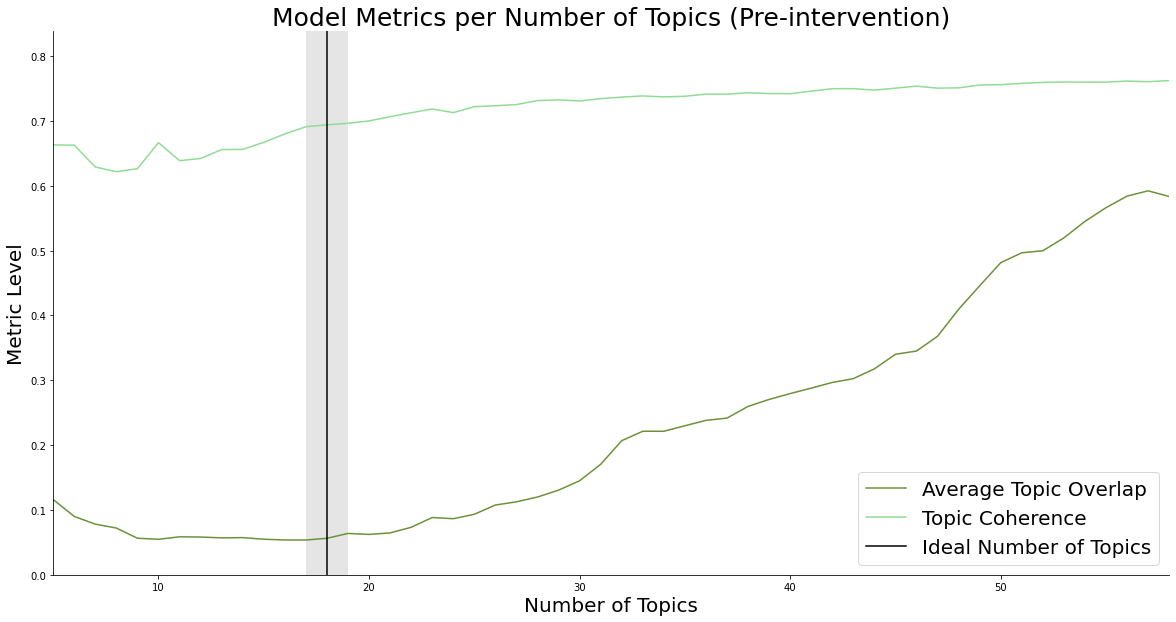

<Figure size 432x288 with 0 Axes>

In [8]:
# creating a dictionary
dirichlet_dict_fork = corpora.Dictionary(data_lemmatized_fork)
bow_corpus_fork = [dirichlet_dict_fork.doc2bow(text) for text in data_lemmatized_fork]


# considering 5-60 topics, as the last is cut off
num_topics = list(range(60)[5:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = gensim.models.LdaModel(corpus=bow_corpus_fork,
                             id2word=dirichlet_dict_fork,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus_fork),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            sims.append(jaccard_similarity(topic1, topic2))
        
        jaccard_sims.append(sims)
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]
print('1', mean_stabilities)

coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized_fork, dictionary=id2word_fork, coherence='c_v').get_coherence() for i in num_topics[:-1]]
print('2', coherences)
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
print('3', coh_sta_diffs)
coh_sta_max = max(coh_sta_diffs)
print('4', coh_sta_max)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
print('5', coh_sta_max_idxs)
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
print('6', ideal_topic_num_index)
ideal_topic_num_fork = num_topics[ideal_topic_num_index]
print('7', ideal_topic_num_fork)

print(coherences[12])

# creating own colour palette
colors = ["#6B9138", "#90DC94"]
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num_fork, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num_fork - 1, xmax=ideal_topic_num_fork + 1, alpha=0.2, facecolor='grey')

# setting up the limits of the plot
y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([5, num_topics[-1]-1])
# removing the top and the right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
                
ax.axes.set_title('Model Metrics per Number of Topics (Pre-intervention)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()
plt.savefig('ideal_topicnr_fork.jpg')

#### SHOE

1 [0.11229424692693057, 0.07366895556550729, 0.07551468225405222, 0.07599853410697989, 0.07057174491838737, 0.06196625508878473, 0.06389236567954026, 0.06352551074036485, 0.06698397463368505, 0.0674037098603387, 0.06621845271864012, 0.05942355532900335, 0.06284656985483043, 0.06956329488615977, 0.07556774632033056, 0.0728097404620891, 0.07339945074032575, 0.08475938356385848, 0.09567326792572865, 0.09094025776821879, 0.08875363402437314, 0.10359453608758443, 0.11583963091829147, 0.10913017446508706, 0.12290114924791688, 0.15547655058868742, 0.16639819358129657, 0.16930688737651958, 0.1922454392056061, 0.22313156880791182, 0.23208546475089845, 0.240765284384129, 0.24968213652568316, 0.2595050825999803, 0.2645854426920888, 0.2627998375000238, 0.2698627532801229, 0.28311876467443103, 0.29623694100977216, 0.3021013099957476, 0.313275135469282, 0.33509966387219037, 0.3523659139956782, 0.3662854002229828, 0.3856386573839448, 0.42382387820351924, 0.4850629018539345, 0.5222866343301541, 0.5131

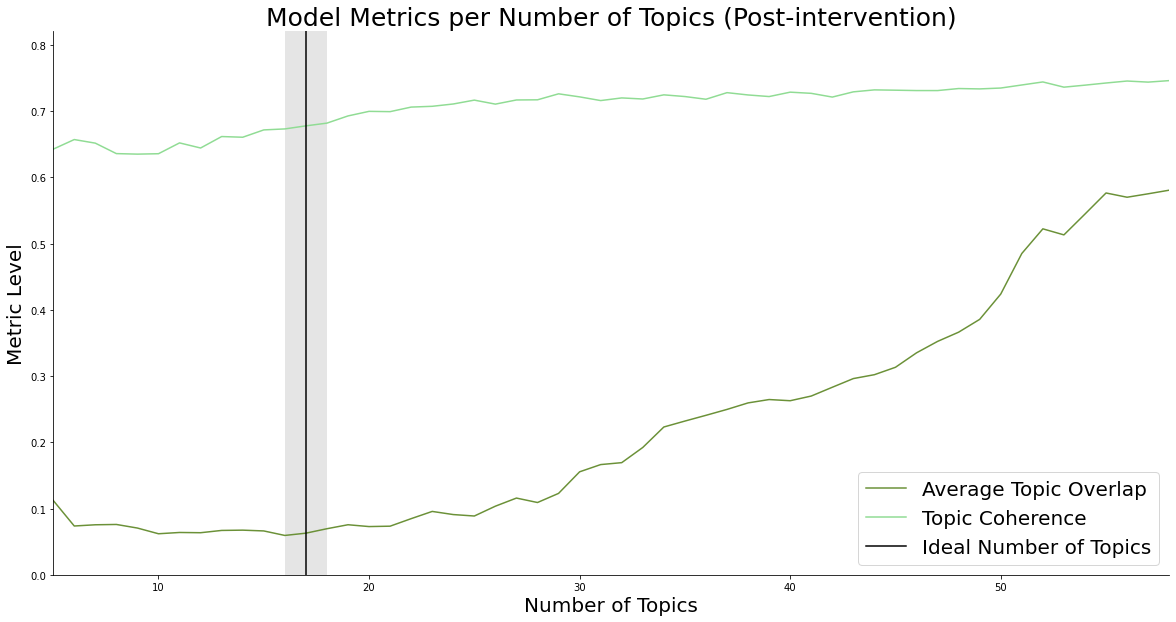

<Figure size 432x288 with 0 Axes>

In [16]:
# creating a dictionary
dirichlet_dict_shoe = corpora.Dictionary(data_lemmatized_shoe)
bow_corpus_shoe = [dirichlet_dict_shoe.doc2bow(text) for text in data_lemmatized_shoe]

# considering 5-60 topics, as the last is cut off
num_topics = list(range(60)[5:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = gensim.models.LdaModel(corpus=bow_corpus_shoe,
                             id2word=dirichlet_dict_shoe,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus_shoe),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]
print('1', mean_stabilities)

coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized_shoe, dictionary=id2word_shoe, coherence='c_v').get_coherence() for i in num_topics[:-1]]

print('2', coherences)
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
print('3', coh_sta_diffs)
coh_sta_max = max(coh_sta_diffs)
print('4', coh_sta_max)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
print('5', coh_sta_max_idxs)
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
print('6', ideal_topic_num_index)
ideal_topic_num_shoe = num_topics[ideal_topic_num_index]
print('7', ideal_topic_num_shoe)

# creating own colour palette
colors = ["#6B9138", "#90DC94"]
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num_shoe, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num_shoe - 1, xmax=ideal_topic_num_shoe + 1, alpha=0.2, facecolor='grey')

# setting up the limits of the plot
y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([5, num_topics[-1]-1])
# removing the top and the right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
                
ax.axes.set_title('Model Metrics per Number of Topics (Post-intervention)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()
plt.savefig('ideal_topicnr_shoe.jpg')

### Create LDA models again

In [5]:
# creating a dictionary
dirichlet_dict_fork = corpora.Dictionary(data_lemmatized_fork)
bow_corpus_fork = [dirichlet_dict_fork.doc2bow(text) for text in data_lemmatized_fork]

# creating a dictionary
dirichlet_dict_shoe = corpora.Dictionary(data_lemmatized_shoe)
bow_corpus_shoe = [dirichlet_dict_shoe.doc2bow(text) for text in data_lemmatized_shoe]

In [20]:
# FORK
# number of topics
num_topics = 17

# build LDA model
lda_model_fork = gensim.models.LdaMulticore(corpus=bow_corpus_fork,
                                       id2word=id2word_fork,
                                       num_topics=num_topics)
# print the keyword in the 10 topics
#pprint(lda_model_fork.print_topics())
doc_lda_fork = lda_model_fork[corpus_fork]

# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared_fork = pyLDAvis.gensim_models.prepare(lda_model_fork, corpus_fork, id2word_fork)
pyLDAvis.save_html(LDAvis_prepared_fork, 'lda-results/ldavis_prepared_fork_'+ str(num_topics) +'.html')

# SHOE
num_topics = 18

# build LDA model
lda_model_shoe = gensim.models.LdaMulticore(corpus=bow_corpus_shoe,
                                       id2word=id2word_shoe,
                                       num_topics=num_topics)
# print the keyword in the 10 topics
#pprint(lda_model_shoe.print_topics())
doc_lda_shoe = lda_model_shoe[corpus_shoe]

# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared_shoe = pyLDAvis.gensim_models.prepare(lda_model_shoe, corpus_shoe, id2word_shoe)
pyLDAvis.save_html(LDAvis_prepared_shoe, 'lda-results/ldavis_prepared_shoe_'+ str(num_topics) +'.html')

### Evaluate model

In [21]:
# lower the perplexity better the model
# higher the topic coherence, the topic is more human interpretable
# log likelihood: higher the better

# compute perplexity
print('\nFork Perplexity: ', lda_model_fork.log_perplexity(bow_corpus_fork))  
# a measure of how good the model is. lower the better.

# compute perplexity
print('\nShoe Perplexity: ', lda_model_shoe.log_perplexity(bow_corpus_shoe))  
# a measure of how good the model is. lower the better.

# compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model_fork, texts=data_lemmatized_fork, dictionary=id2word_fork, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nFork Coherence Score: ', coherence_lda)

# compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model_shoe, texts=data_lemmatized_shoe, dictionary=id2word_shoe, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nShoe Coherence Score: ', coherence_lda)

# compute log likelihood
# print('\nLog Likelihood: ', lda_model_fork.score(data_vectorized))


Fork Perplexity:  -7.266728488510497

Shoe Perplexity:  -7.167353224380229

Fork Coherence Score:  0.7114658088515391

Shoe Coherence Score:  0.7038274131252262


### Visualise model

In [98]:
# FORK
# number of topics
num_topics = ideal_topic_num_fork

# build LDA model
lda_model_fork = gensim.models.LdaMulticore(corpus=bow_corpus_fork,
                                       id2word=id2word_fork,
                                       num_topics=num_topics)

doc_lda_fork = lda_model_shoe[corpus_fork]

# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared_fork = pyLDAvis.gensim_models.prepare(lda_model_fork, corpus_fork, id2word_fork)
pyLDAvis.save_html(LDAvis_prepared_fork, 'lda-results/ldavis_prepared_fork_'+ str(num_topics) +'.html')

# SHOE
# number of topics
num_topics = ideal_topic_num_shoe

# build LDA model
lda_model_shoe = gensim.models.LdaMulticore(corpus=bow_corpus_shoe,
                                       id2word=id2word_shoe,
                                       num_topics=num_topics)

doc_lda_shoe = lda_model_shoe[corpus_shoe]

# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared_shoe = pyLDAvis.gensim_models.prepare(lda_model_shoe, corpus_shoe, id2word_shoe)
pyLDAvis.save_html(LDAvis_prepared_shoe, 'lda-results/ldavis_prepared_shoe_'+ str(num_topics) +'.html')

## Semantic distance

### Creating dataframes of the answers based on participants

In [7]:
# FORK

fork_subject = [0] * len(data_lemmatized_fork)
fork_use_wo_na = [0] * len(data_lemmatized_fork)
i2 = 0
i3 = 0

for i in range(len(data_new['fork_use_nlp'])):
    if pd.notna(data_new['fork_use_nlp'].iloc[i]):
        fork_subject[i2] = int(data_new['subject'].iloc[i])
        fork_use_wo_na[i2] = data_new['fork_use_nlp'].iloc[i]
        i2 = i2 + 1
        
fork_subject_df = pd.DataFrame(list(zip(fork_subject, fork_use_wo_na)),
               columns =['subject', 'use'])

# SHOE

shoe_subject = [0] * len(data_lemmatized_shoe)
shoe_use_wo_na = [0] * len(data_lemmatized_shoe)
i2 = 0
i3 = 0

for i in range(len(data_new['shoe_use_nlp'])):
    if pd.notna(data_new['shoe_use_nlp'].iloc[i]):
        shoe_subject[i2] = int(data_new['subject'].iloc[i])
        shoe_use_wo_na[i2] = data_new['shoe_use_nlp'].iloc[i]
        i2 = i2 + 1
        
shoe_subject_df = pd.DataFrame(list(zip(shoe_subject, shoe_use_wo_na)),
               columns =['subject', 'use'])

### Defining the functions

In [8]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

### Flexibility

In [18]:
data_new = pd.read_csv("data_nlp.csv", sep=',')

# I'm also saving the amount of answers for each subjects, because it'll be used later on
fork_amount_answers = [0] * 20
shoe_amount_answers = [0] * 20

# FORK

# create CBOW model
model_fork = gensim.models.Word2Vec(fork_processed, min_count = 1,
                              vector_size = 100, window = 5)

jac_sim = 0
sem_dis = 0
amount = 0
fork_mean_sem_dis = [0] * 20
fork_mean_jac_sim = [0] * 20
i3 = 0

# iterating through the subjects
for i in range(1, len(fork_subject_df['use'])):
    if fork_subject_df['subject'].iloc[i] != fork_subject_df['subject'].iloc[i-1]:
        fork_mean_sem_dis[i3] = round(sem_dis/amount, 2)
        fork_mean_jac_sim[i3] = round(jac_sim/amount, 2)
        fork_amount_answers[i3] = amount
        jac_sim = 0
        sem_dis = 0
        amount = 0
        i3 = i3 + 1
        i = i + 1
    sem_dis = sem_dis + cos_similarity(nlp(fork_subject_df['use'].iloc[i]).vector, nlp(fork_subject_df['use'].iloc[i-1]).vector)
    jac_sim = jac_sim + jaccard_similarity(fork_subject_df['use'].iloc[i], fork_subject_df['use'].iloc[i-2])
    amount = amount + 1

fork_mean_sem_dis[i3] = round(sem_dis/amount, 2)
fork_mean_jac_sim[i3] = round(jac_sim/amount, 2)

# SHOE

# create CBOW model
model_shoe = gensim.models.Word2Vec(shoe_processed, min_count = 1,
                              vector_size = 100, window = 5)

jac_sim = 0
sem_dis = 0
amount = 0
shoe_mean_sem_dis = [0] * 20
shoe_mean_jac_sim = [0] * 20
i3 = 0

# iterating through the subjects
for i in range(1, len(shoe_subject_df['use'])):
    if shoe_subject_df['subject'].iloc[i] != shoe_subject_df['subject'].iloc[i-1]:
        shoe_mean_sem_dis[i3] = round(sem_dis/amount, 2)
        shoe_mean_jac_sim[i3] = round(jac_sim/amount, 2)
        shoe_amount_answers[i3] = amount
        jac_sim = 0
        sem_dis = 0
        amount = 0
        i3 = i3 + 1
        i = i + 1
    sem_dis = sem_dis + cos_similarity(nlp(shoe_subject_df['use'].iloc[i]).vector, nlp(shoe_subject_df['use'].iloc[i-1]).vector)
    jac_sim = jac_sim + jaccard_similarity(shoe_subject_df['use'].iloc[i], shoe_subject_df['use'].iloc[i-2])
    amount = amount + 1
    
shoe_mean_sem_dis[i3] = round(sem_dis/amount, 2)
shoe_mean_jac_sim[i3] = round(jac_sim/amount, 2)

data_sem_dis = pd.DataFrame(list(zip(fork_mean_sem_dis, shoe_mean_sem_dis, fork_mean_jac_sim, shoe_mean_jac_sim)),
               columns =['fork_cos_dis', 'shoe_cos_dis', 'fork_jac_sim', 'shoe_jac_sim'])

data_sem_dis['subject'] = range(1, 21)

data_cond = pd.read_csv("conditions.csv", sep=';')
data_sem_dis['condition'] = data_cond['condition']

data_sem_dis.to_csv('data_sem_dis_flex.csv', index=False)
#data_sem_dis.to_excel('data_sem_dis.xlsx')

In [31]:
flex_fork_np = []
flex_fork_pl = []
flex_shoe_np = []
flex_shoe_pl = []

for i in range(0,20):
    if(data_sem_dis['condition'].iloc[i] == 0):
        flex_fork_np.append(data_sem_dis['fork_cos_dis'].iloc[i])
        flex_shoe_np.append(data_sem_dis['shoe_cos_dis'].iloc[i])
    if(data_sem_dis['condition'].iloc[i] == 1):
        flex_fork_pl.append(data_sem_dis['fork_cos_dis'].iloc[i])
        flex_shoe_pl.append(data_sem_dis['shoe_cos_dis'].iloc[i])

print(statistics.mean(flex_fork_np))
print(statistics.stdev(flex_fork_np))

0.039
0.01100504934614612


### Originality

#### Tokenizing the definitions

In [25]:
# remove punctuation and stopwords
fork_def_processed = []
shoe_def_processed = []
i = 0
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

fork_def = 'an implement with two or more prongs used especially for taking up (as in eating), pitching, or digging'
shoe_def = 'an outer covering for the human foot typically having a thick or stiff sole with an attached heel and an upper part of lighter material (such as leather)'

lemmatized_fork_def = lemmatize_with_postag(fork_def)
lemmatized_shoe_def = lemmatize_with_postag(shoe_def)

for word in lemmatized_fork_def.split():
        if not word in punc and stop_words:
            fork_def_processed.append(word)

for word in lemmatized_shoe_def.split():
        if not word in punc and stop_words:
            shoe_def_processed.append(word)
            
fork_def_processed_str = ' '.join(fork_def_processed)
shoe_def_processed_str = ' '.join(shoe_def_processed)

[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ucloud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Calculating

In [26]:
# FORK

jac_sim = 0
sem_dis = 0
amount = 0
fork_mean_sem_dis = [0] * 20
fork_mean_jac_sim = [0] * 20
i3 = 0

# iterating through the subjects
for i in range(1, len(fork_subject_df['use'])):
    if fork_subject_df['subject'].iloc[i] != fork_subject_df['subject'].iloc[i-1]:
        fork_mean_sem_dis[i3] = round(sem_dis/amount, 2)
        fork_mean_jac_sim[i3] = round(jac_sim/amount, 2)
        jac_sim = 0
        sem_dis = 0
        amount = 0
        i3 = i3 + 1
        i = i + 1
    sem_dis = sem_dis + cos_similarity(nlp(fork_subject_df['use'].iloc[i]).vector, nlp(fork_def_processed_str).vector)
    jac_sim = jac_sim + jaccard_similarity(fork_subject_df['use'].iloc[i], fork_def_processed_str)
    amount = amount + 1

fork_mean_sem_dis[i3] = round(sem_dis/amount, 2)
fork_mean_jac_sim[i3] = round(jac_sim/amount, 2)

# SHOE

jac_sim = 0
sem_dis = 0
amount = 0
shoe_mean_sem_dis = [0] * 20
shoe_mean_jac_sim = [0] * 20
i3 = 0

# iterating through the subjects
for i in range(1, len(shoe_subject_df['use'])):
    if shoe_subject_df['subject'].iloc[i] != shoe_subject_df['subject'].iloc[i-1]:
        shoe_mean_sem_dis[i3] = round(sem_dis/amount, 2)
        shoe_mean_jac_sim[i3] = round(jac_sim/amount, 2)
        jac_sim = 0
        sem_dis = 0
        amount = 0
        i3 = i3 + 1
        i = i + 1
    sem_dis = sem_dis + cos_similarity(nlp(shoe_subject_df['use'].iloc[i]).vector, nlp(shoe_def_processed_str).vector)
    jac_sim = jac_sim + jaccard_similarity(shoe_subject_df['use'].iloc[i], shoe_def_processed_str)
    amount = amount + 1
    
shoe_mean_sem_dis[i3] = round(sem_dis/amount, 2)
shoe_mean_jac_sim[i3] = round(jac_sim/amount, 2)

data_sem_dis = pd.DataFrame(list(zip(fork_mean_sem_dis, shoe_mean_sem_dis, fork_mean_jac_sim, shoe_mean_jac_sim)),
               columns =['fork_cos_dis', 'shoe_cos_dis', 'fork_jac_sim', 'shoe_jac_sim'])

data_sem_dis['subject'] = range(1, 21)

data_cond = pd.read_csv("conditions.csv", sep=';')
data_sem_dis['condition'] = data_cond['condition']

data_sem_dis.to_csv('data_sem_dis_ori.csv', index=False)
#data_sem_dis.to_excel('data_sem_dis.xlsx')

In [27]:
ori_fork_np = []
ori_fork_pl = []
ori_shoe_np = []
ori_shoe_pl = []

for i in range(0,20):
    if(data_sem_dis['condition'].iloc[i] == 0):
        ori_fork_np.append(data_sem_dis['fork_cos_dis'].iloc[i])
        ori_shoe_np.append(data_sem_dis['shoe_cos_dis'].iloc[i])
    if(data_sem_dis['condition'].iloc[i] == 1):
        ori_fork_pl.append(data_sem_dis['fork_cos_dis'].iloc[i])
        ori_shoe_pl.append(data_sem_dis['shoe_cos_dis'].iloc[i])

print(statistics.mean(ori_fork_np))
print(statistics.stdev(ori_fork_np))

0.039
0.01100504934614612


### Analysing the results based on conditions

#### Flexibility

In [24]:
# t tests
t_flex_np = stats.ttest_ind(flex_fork_np,flex_shoe_np)
t_flex_pl = stats.ttest_ind(flex_fork_pl,flex_shoe_pl)

print('Flexibility cos dis non-playful:', t_flex_np)
print('Flexibility cos dis playful:', t_flex_pl)
print('Flexibility cos dis between conditions:', stats.ttest_ind(flex_shoe_np,flex_shoe_pl))

Flexibility cos dis non-playful: Ttest_indResult(statistic=-2.3707823390807996, pvalue=0.029118522391740325)
Flexibility cos dis playful: Ttest_indResult(statistic=-1.1274690420042315, pvalue=0.2743498493532012)
Flexibility cos dis between conditions: Ttest_indResult(statistic=0.1285058810634358, pvalue=0.8991735704606747)


#### Originality

In [28]:
# t tests
t_sem_dis_np = stats.ttest_ind(ori_fork_np,ori_shoe_np)
t_sem_dis_pl = stats.ttest_ind(ori_fork_pl,ori_shoe_pl)

print('Originality cos dis non-playful:', t_sem_dis_np)
print('Originality cos dis playful:', t_sem_dis_pl)
print('Originality cos dis between conditions:', stats.ttest_ind(ori_shoe_np,ori_shoe_pl))

Originality cos dis non-playful: Ttest_indResult(statistic=1.91359465003153, pvalue=0.07171137104674273)
Originality cos dis playful: Ttest_indResult(statistic=2.9056835241765415, pvalue=0.009428916357303488)
Originality cos dis between conditions: Ttest_indResult(statistic=0.3011735166346145, pvalue=0.7667335945439044)


### Comparing semantic distance over time

13
14


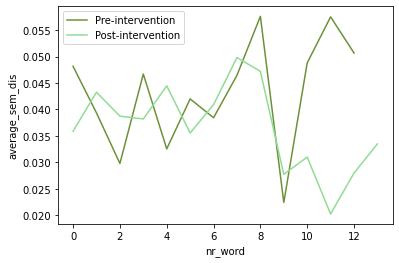

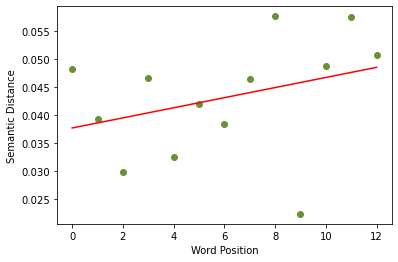

Pearsons correlation (pre-intervention): 0.335
0.0008988249540447342
0.03771857582283407
0.2630622752464455
0.0007620082719367185


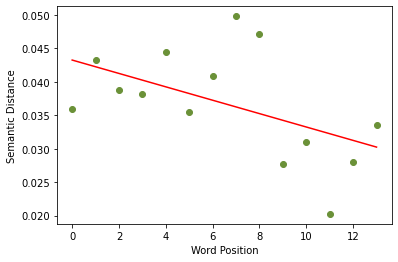

Pearsons correlation (post-intervention): -0.509
-0.0010014736373018102
0.04326480720517872
0.0631037857883098
0.000489021645644611


In [45]:
# finding the most answers given by a participant
max_fork_answers = max(fork_amount_answers)
max_shoe_answers = max(shoe_amount_answers)

i = 0
i3 = 0
nr = 0
amount = 0

fork_temporal_analysis = pd.DataFrame({'nr_word': list(range(0, max_fork_answers)),
                                       'average_sem_dis': [0] * max_fork_answers,
                                        'occurrence': [0] * max_fork_answers})

shoe_temporal_analysis = pd.DataFrame({'nr_word': list(range(0, max_shoe_answers)),
                                       'average_sem_dis': [0] * max_shoe_answers,
                                        'occurrence': [0] * max_shoe_answers})

# FORK
for i in range(1, len(fork_subject_df['use'])):
    if fork_subject_df['subject'].iloc[i] != fork_subject_df['subject'].iloc[i-1]:
        nr = 0
        amount = 0
    sem_dis = cos_similarity(nlp(fork_subject_df['use'].iloc[i]).vector, nlp(fork_def_processed_str).vector)
    fork_temporal_analysis['average_sem_dis'].iloc[nr] = fork_temporal_analysis['average_sem_dis'].iloc[nr] + sem_dis
    fork_temporal_analysis['occurrence'].iloc[nr] = fork_temporal_analysis['occurrence'].iloc[nr] + 1
    nr = nr + 1
    sem_dis = 0

# calculating average
for i in range(0, len(fork_temporal_analysis['nr_word'])):
    fork_temporal_analysis['average_sem_dis'].iloc[i] = fork_temporal_analysis['average_sem_dis'].iloc[i]/fork_temporal_analysis['occurrence'].iloc[i]

#SHOE
for i in range(1, len(shoe_subject_df['use'])):
    if shoe_subject_df['subject'].iloc[i] != shoe_subject_df['subject'].iloc[i-1]:
        nr = 0
        amount = 0
    sem_dis = cos_similarity(nlp(shoe_subject_df['use'].iloc[i]).vector, nlp(fork_def_processed_str).vector)
    shoe_temporal_analysis['average_sem_dis'].iloc[nr] = shoe_temporal_analysis['average_sem_dis'].iloc[nr] + sem_dis
    shoe_temporal_analysis['occurrence'].iloc[nr] = shoe_temporal_analysis['occurrence'].iloc[nr] + 1
    nr = nr + 1
    sem_dis = 0

# calculating average
for i in range(0, len(shoe_temporal_analysis['nr_word'])):
    shoe_temporal_analysis['average_sem_dis'].iloc[i] = shoe_temporal_analysis['average_sem_dis'].iloc[i]/shoe_temporal_analysis['occurrence'].iloc[i]

# filtering datapoints where the occurence is not greater than 2
fork_temporal_analysis = fork_temporal_analysis[fork_temporal_analysis['occurrence'] > 2]
print(len(fork_temporal_analysis['occurrence']))
shoe_temporal_analysis = shoe_temporal_analysis[shoe_temporal_analysis['occurrence'] > 2]
print(len(shoe_temporal_analysis['occurrence']))

# visualising
colors = ["#6B9138", "#90DC94"]
sns.set_palette(sns.color_palette(colors))
sns.lineplot(data=fork_temporal_analysis, x="nr_word", y="average_sem_dis", label='Pre-intervention')
sns.lineplot(data=shoe_temporal_analysis, x="nr_word", y="average_sem_dis", label='Post-intervention')
plt.legend(fontsize=10)
plt.show()

# FORK

plt.scatter(fork_temporal_analysis['nr_word'], fork_temporal_analysis['average_sem_dis'])
m, b = np.polyfit(fork_temporal_analysis['nr_word'], fork_temporal_analysis['average_sem_dis'], 1)
plt.plot(fork_temporal_analysis['nr_word'], m*fork_temporal_analysis['nr_word']+b, color='red')
plt.xlabel("Word Position")
plt.ylabel("Semantic Distance")
plt.show()

corr, p = pearsonr(fork_temporal_analysis['nr_word'], fork_temporal_analysis['average_sem_dis'])
print('Pearsons correlation (pre-intervention): %.3f' % corr)

result = linregress(fork_temporal_analysis['nr_word'], fork_temporal_analysis['average_sem_dis'])
print(result.slope)
print(result.intercept)
print(result.pvalue)
print(result.stderr)

# SHOE

plt.scatter(shoe_temporal_analysis['nr_word'], shoe_temporal_analysis['average_sem_dis'])
m, b = np.polyfit(shoe_temporal_analysis['nr_word'], shoe_temporal_analysis['average_sem_dis'], 1)
plt.plot(shoe_temporal_analysis['nr_word'], m*shoe_temporal_analysis['nr_word']+b, color='red')
plt.xlabel("Word Position")
plt.ylabel("Semantic Distance")
plt.show()

corr, p = pearsonr(shoe_temporal_analysis['nr_word'], shoe_temporal_analysis['average_sem_dis'])
print('Pearsons correlation (post-intervention): %.3f' % corr)

result = linregress(shoe_temporal_analysis['nr_word'], shoe_temporal_analysis['average_sem_dis'])
print(result.slope)
print(result.intercept)
print(result.pvalue)
print(result.stderr)